In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

In [2]:
def read_data(filename):
    data = pd.read_csv(filename)
    y = data.iloc[:, -1:]
    yReal = []
    xReal = []
    for i in data.index:
        if y["class"][i] == 'P':
            yReal.append(-1)
        else:
            yReal.append(1)
        #print(data["x"][i], data["y"][i])
        xReal.append(np.array([data["x"][i], data["y"][i]]))
    return np.array(xReal), np.array(yReal)
XChips, YChips = read_data("chips.csv")
print(len(XChips[0]))
XGeyser, YGeyser = read_data("geyser.csv")
#print(XChips, YChips)

2


In [3]:
def linear(x, y):
    return np.dot(x, y.T)

def poly(x, y, d):
    return (np.dot(x, y.T) + 1) ** d

def gaus(x, y, betta):
    return np.exp(-betta * (np.linalg.norm(x - y) ** 2))

def calc(kernel, x, y, d = 0, betta = 0):
    if kernel == "linear":
        return linear(x, y)
    elif kernel == "poly":
        return poly(x, y, d)
    else:
        return gaus(x, y, betta)

In [4]:
def calculate_matrix(X, kernel, d = 0, betta = 0):
    n = len(X)
    K = [[0.0 for i in range(n)] for j in range(n)]
    for i in range(len(X)):
        for j in range(len(X)):
            K[i][j] = calc(kernel, X[i], X[j], d, betta)
    return K

In [26]:
def SVM(n, Y, K, C):
    def getRandom(i, n):
        t = -1
        while True:
            t = random.randint(0, n - 1)
            if t != i:
                break
        return t

    def getE(ind):
        res = 0.0
        for i in range(n):
            res += alphas[i] * Y[i] * K[i][ind]
        return res + b - Y[ind]

    def getLH(i, j, c):
        L = 0.0
        H = 0.0
        if Y[i] == Y[j]:
            L = max(L, alphas[i] + alphas[j] - c)
            H = min(alphas[i] + alphas[j], c)
        else:
            L = max(L, alphas[j] - alphas[i])
            H = min(c, c + alphas[j] - alphas[i])
        return L, H

    alphas = [0.0 for i in range(n)]
    passes = 0
    max_passes = 10
    b = 0.0
    tol = 1e-7
    xx = 0
    start_time = time.time()
    #print(K)
    while time.time() - start_time < 1 and xx < 500:
        qq = 0
        for i in range(n):
            xx += 1
            E_i = getE(i)
            if (E_i * Y[i] < -tol and alphas[i] < C) or (E_i * Y[i] > tol and alphas[i] > 0):
                j = getRandom(i, n)
                # print("j=", j)
                E_j = getE(j)
                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]
                L, H = getLH(i, j, C)
                # print(i, j, L, H)
                if abs(L - H) < tol:
                    continue
                tetta = 2.0 * K[i][j] - K[i][i] - K[j][j]
                if tetta > -tol:
                    continue
                new_alpha = alphas[j] - Y[j] * (E_i - E_j) / tetta
                alphas[j] = new_alpha
                if alphas[j] > H:
                    alphas[j] = H
                elif alphas[j] < L:
                    alphas[j] = L
                if abs(alphas[j] - alpha_j_old) < tol:
                    continue
                alphas[i] = alphas[i] + Y[i] * Y[j] * (alpha_j_old - alphas[j])
                b1 = b - E_i - Y[i] * (alphas[i] - alpha_i_old) * K[i][i] - Y[j] * (alphas[j] - alpha_j_old) * K[i][j]
                b2 = b - E_j - Y[i] * (alphas[i] - alpha_i_old) * K[i][j] - Y[j] * (alphas[j] - alpha_j_old) * K[j][j]
                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
        if (qq == 0):
            passes += 1
        else:
            passes = 0
    return alphas, b

def predict(X_train, Y_train, alphas, b, x, kernel, d = 0, betta = 0):
    w = 0
    for i in range(len(X_train)):
        w += Y_train[i] * alphas[i] * calc(kernel, x, X_train[i], d, betta)
    return np.sign(w + b)

In [27]:
def cross_valid(X, y, kernel, c, d = 0, betta = 0):
    kf = KFold(4)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        K = calculate_matrix(X_train, kernel, d, betta)
        #print("firstK =", K)
        alphas, b = SVM(len(X_train), y_train, K, c)
        #print(alphas, b)
        y_true = []
        y_pred = []
        for i in range(len(X_test)):
            y_true.append(y_test[i])
            y_pred.append(predict(X_train, y_train, alphas, b, X_test[i], kernel, d, betta))
        scores.append(accuracy_score(y_true, y_pred))
    return np.average(np.array(scores))

In [28]:
def bestParams(X, y, kernel):
    C=[0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
    maxi = 0
    best = (0.0, 0, 0)
    for c in C:
        for d in range(2, 6):
            for betta in range(1, 6):
                t = cross_valid(X, y, kernel, c, d, betta)
                print(c, d, t)
                if t > maxi:
                    best = (c, d, betta)
                    maxi = t
    print(kernel, best, maxi)
    return best, maxi

In [29]:
def draw(X, y, kernel):
    Q = 110
    xmin = X[0][0]
    xmax = X[0][0]
    ymin = X[0][1]
    ymax = X[0][1]
    for t in X:
        xmin = min(xmin, t[0])
        xmax = max(xmax, t[0])
        ymin = min(ymin, t[1])
        ymax = max(ymax, t[1])
    delta_x =  (xmax - xmin) / Q
    delta_y = (ymax - ymin) / Q
    pts = []
    for i in range(Q):
        for j in range(Q):
            pts.append([xmin + i * delta_x, ymin + j * delta_y])
    params, score = bestParams(X, y, kernel)
    K = calculate_matrix(X, kernel, params[1], params[2])
    alphas, b = SVM(len(X), y, K, params[0])
    ptsGreenx = []
    ptsRedx = []
    ptsGreeny = []
    ptsRedy = []
    for i in pts:
        t = predict(X, y, alphas, b, i, kernel, params[1], params[2])
        if t == 1:
            ptsGreenx.append(i[0])
            ptsGreeny.append(i[1])
        else:
            ptsRedx.append(i[0])
            ptsRedy.append(i[1])
    greenXx = []
    redXx = []
    greenXy = []
    redXy = []
    for i in range(len(X)):
        if y[i] == -1:
            redXx.append(X[i][0])
            redXy.append(X[i][1])
        else:
            greenXx.append(X[i][0])
            greenXy.append(X[i][1])
    plt.scatter(greenXx, greenXy, marker='.', s = 30, color = 'green')
    plt.scatter(redXx, redXy, marker='.', s = 30, color='red')
    plt.scatter(ptsRedx, ptsRedy, marker='.',color='red', alpha = 0.14)
    plt.scatter(ptsGreenx, ptsGreeny, marker='.',color='green', alpha=0.14)
    plt.show()

0.05 2 0.32701149425287357
0.05 2 0.31839080459770114
0.05 2 0.5166666666666666
0.05 2 0.5166666666666666
0.05 2 0.33563218390804594
0.05 3 0.24080459770114943
0.05 3 0.5781609195402299
0.05 3 0.016666666666666666
0.05 3 0.07701149425287357
0.05 3 0.5166666666666666
0.05 4 0.30114942528735633
0.05 4 0.5166666666666666
0.05 4 0.25804597701149423
0.05 4 0.31839080459770114
0.05 4 0.26666666666666666
0.05 5 0.33563218390804594
0.05 5 0.21494252873563216
0.05 5 0.37873563218390804
0.05 5 0.26666666666666666
0.05 5 0.3873563218390805
0.1 2 0.2752873563218391
0.1 2 0.30114942528735633
0.1 2 0.15459770114942528
0.1 2 0.25804597701149423
0.1 2 0.3528735632183908
0.1 3 0.2925287356321839
0.1 3 0.3442528735632184
0.1 3 0.30114942528735633
0.1 3 0.04252873563218391
0.1 3 0.2752873563218391
0.1 4 0.26666666666666666
0.1 4 0.32701149425287357
0.1 4 0.2379310344827586
0.1 4 0.42183908045977014
0.1 4 0.5166666666666666
0.1 5 0.3614942528735632
0.1 5 0.5166666666666666
0.1 5 0.3614942528735632
0.1 5 0

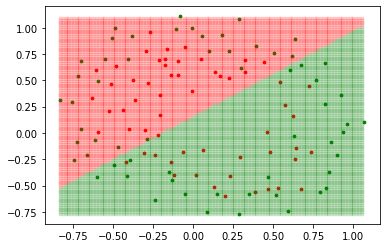

In [9]:
draw(XChips, YChips, "linear")

0.05 2 0.17183908045977012
0.05 2 0.26925287356321836
0.05 2 0.3442528735632184
0.05 2 0.12873563218390804
0.05 2 0.5166666666666666
0.05 3 0.5166666666666666
0.05 3 0.34425287356321843
0.05 3 0.3614942528735632
0.05 3 0.7063218390804598
0.05 3 0.2925287356321839
0.05 4 0.11149425287356321
0.05 4 0.232183908045977
0.05 4 0.15459770114942528
0.05 4 0.4919540229885057
0.05 4 0.317816091954023
0.05 5 0.43908045977011495
0.05 5 0.5586206896551724
0.05 5 0.34425287356321843
0.05 5 0.4020114942528735
0.05 5 0.4132183908045977
0.1 2 0.30114942528735633
0.1 2 0.14597701149425288
0.1 2 0.30114942528735633
0.1 2 0.26666666666666666
0.1 2 0.23218390804597702
0.1 3 0.26666666666666666
0.1 3 0.25804597701149423
0.1 3 0.564367816091954
0.1 3 0.5166666666666666
0.1 3 0.25804597701149423
0.1 4 0.45689655172413796
0.1 4 0.385632183908046
0.1 4 0.4091954022988506
0.1 4 0.49080459770114937
0.1 4 0.24942528735632183
0.1 5 0.5666666666666667
0.1 5 0.4787356321839081
0.1 5 0.22873563218390805
0.1 5 0.429597

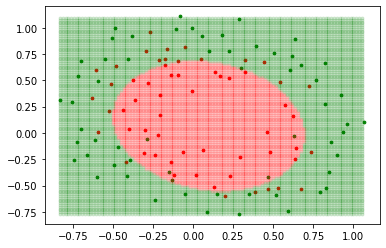

In [12]:
draw(XChips, YChips, "poly")

0.05 2 0.5166666666666666
0.05 2 0.5166666666666666
0.05 2 0.26666666666666666
0.05 2 0.45632183908045976
0.05 2 0.4735632183908046
0.05 3 0.5166666666666666
0.05 3 0.6778735632183908
0.05 3 0.4218390804597701
0.05 3 0.5166666666666666
0.05 3 0.4045977011494253
0.05 4 0.5166666666666666
0.05 4 0.12011494252873563
0.05 4 0.4275862068965517
0.05 4 0.5166666666666666
0.05 4 0.35
0.05 5 0.5166666666666666
0.05 5 0.5166666666666666
0.05 5 0.33563218390804594
0.05 5 0.1028735632183908
0.05 5 0.5166666666666666
0.1 2 0.3442528735632184
0.1 2 0.18045977011494252
0.1 2 0.3442528735632184
0.1 2 0.2580459770114943
0.1 2 0.3701149425287356
0.1 3 0.2235632183908046
0.1 3 0.5166666666666666
0.1 3 0.3528735632183908
0.1 3 0.5166666666666666
0.1 3 0.4735632183908046
0.1 4 0.5166666666666666
0.1 4 0.5166666666666666
0.1 4 0.3442528735632184
0.1 4 0.4649425287356322
0.1 4 0.7333333333333334
0.1 5 0.5442528735632184
0.1 5 0.5166666666666666
0.1 5 0.26666666666666666
0.1 5 0.04252873563218391
0.1 5 0.2925

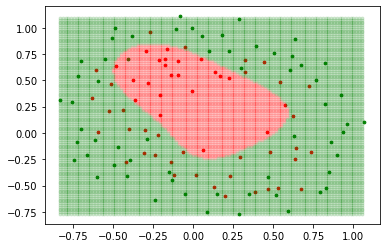

In [11]:
draw(XChips, YChips, "gauss")

0.05 2 0.9055194805194805
0.05 2 0.8696428571428572
0.05 2 0.7600649350649351
0.05 2 0.8830357142857143
0.05 2 0.8696428571428572
0.05 3 0.8874188311688311
0.05 3 0.900974025974026
0.05 3 0.8874188311688311
0.05 3 0.7697240259740259
0.05 3 0.8831168831168832
0.05 4 0.7802759740259739
0.05 4 0.8206168831168832
0.05 4 0.9055194805194805
0.05 4 0.8430194805194806
0.05 4 0.9055194805194805
0.05 5 0.900974025974026
0.05 5 0.8830357142857144
0.05 5 0.8698051948051948
0.05 5 0.7892857142857144
0.05 5 0.8070616883116883
0.1 2 0.9055194805194805
0.1 2 0.900974025974026
0.1 2 0.7352272727272727
0.1 2 0.8691558441558441
0.1 2 0.825
0.1 3 0.8340097402597402
0.1 3 0.8607954545454546
0.1 3 0.9010551948051948
0.1 3 0.8828733766233766
0.1 3 0.8340909090909091
0.1 4 0.8919642857142857
0.1 4 0.7802759740259739
0.1 4 0.8831168831168832
0.1 4 0.9010551948051948
0.1 4 0.8738636363636364
0.1 5 0.8785714285714286
0.1 5 0.6625
0.1 5 0.8875811688311689
0.1 5 0.8965909090909091
0.1 5 0.8652597402597403
0.5 2 0.

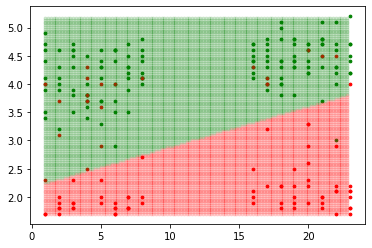

In [30]:
draw(XGeyser, YGeyser, "linear")


0.05 2 0.8116883116883116
0.05 2 0.7393668831168831
0.05 2 0.8331168831168831
0.05 2 0.8422077922077922
0.05 2 0.7178571428571429
0.05 3 0.6303571428571428
0.05 3 0.4411525974025974
0.05 3 0.41461038961038965
0.05 3 0.6478084415584415
0.05 3 0.6707792207792207
0.05 4 0.6121753246753247
0.05 4 0.5318181818181819
0.05 4 0.4737824675324675
0.05 4 0.5678571428571428
0.05 4 0.6489448051948052
0.05 5 0.5943181818181819
0.05 5 0.7659090909090909
0.05 5 0.6638798701298702
0.05 5 0.6625811688311689
0.05 5 0.6034902597402597
0.1 2 0.7024350649350649
0.1 2 0.7671266233766234
0.1 2 0.6803571428571429
0.1 2 0.7701298701298701
0.1 2 0.8023538961038961
0.1 3 0.5270292207792208
0.1 3 0.7079545454545454
0.1 3 0.578327922077922
0.1 3 0.6124188311688311
0.1 3 0.5929383116883117
0.1 4 0.41461038961038965
0.1 4 0.5184253246753247
0.1 4 0.5267857142857143
0.1 4 0.6841720779220779
0.1 4 0.5588474025974026
0.1 5 0.4411525974025974
0.1 5 0.5633116883116883
0.1 5 0.599025974025974
0.1 5 0.6579545454545455
0.1 5

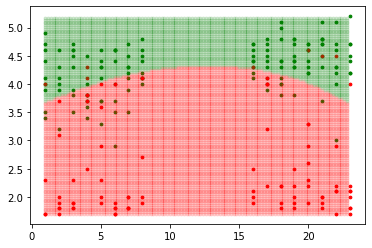

In [18]:
draw(XGeyser, YGeyser, "poly")


0.05 2 0.6079545454545454
0.05 2 0.4874188311688311
0.05 2 0.5262175324675324
0.05 2 0.45478896103896105
0.05 2 0.4874188311688311
0.05 3 0.5455357142857143
0.05 3 0.6034902597402597
0.05 3 0.6034902597402597
0.05 3 0.5397727272727273
0.05 3 0.6168831168831168
0.05 4 0.5320616883116883
0.05 4 0.6034902597402597
0.05 4 0.6034902597402597
0.05 4 0.6034902597402597
0.05 4 0.6079545454545454
0.05 5 0.5398538961038961
0.05 5 0.48157467532467535
0.05 5 0.6079545454545454
0.05 5 0.6034902597402597
0.05 5 0.6125811688311689
0.1 2 0.6034902597402597
0.1 2 0.536525974025974
0.1 2 0.5275162337662338
0.1 2 0.5678571428571428
0.1 2 0.5588474025974026
0.1 3 0.5133928571428571
0.1 3 0.5678571428571428
0.1 3 0.5633928571428571
0.1 3 0.5588474025974026
0.1 3 0.6034902597402597
0.1 4 0.5262175324675324
0.1 4 0.6080357142857143
0.1 4 0.5366071428571428
0.1 4 0.6079545454545454
0.1 4 0.48157467532467535
0.1 5 0.5366071428571428
0.1 5 0.4874188311688311
0.1 5 0.5306818181818181
0.1 5 0.5443181818181818
0.1

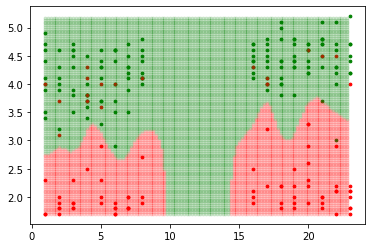

In [19]:
draw(XGeyser, YGeyser, "gauss")
